In [1]:
import cv2
import os
import numpy as np
import warnings
import xml.etree.ElementTree as ET
import time
from matplotlib.patches import Rectangle
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt

In [2]:
def plot_layout(image, overlay, GT= False):

    if GT:
        legend_data = [
           [
            0,
            [
                0,
                0,
                0
            ],
            "Background"
        ],
        [
            1,
            [
                255,
                0,
                0
            ],
            "Text region"
        ],
        [
            2,
            [
                255,
                125,
                0
            ],
            "heading"
        ],
        [
            3,
            [
                255,
                0,
                125
            ],
            "Header"
        ],
        [
            4,
            [
                125,
                125,
                125
            ],
            "Catch"
        ],
        [
            5,
            [
                125,
                125,
                0
            ],
            "Signature"
        ],
        [
            6,
            [
                0,
                125,
                255
            ],
            "Decoration"
        ],
        [
            7,
            [
                0,
                125,
                0
            ],
            "Page number"
        ],
        [
            8,
            [
                125,
                125,
                125
            ],
            "Marginal"
        ],
        [
            9,
            [
                0,
                125,
                255
            ],
            "Drop capital"
        ],

            [
            10,
            [
                125,
                0,
                125
            ],
            "Annotation"
        ],

        [
            11,
            [
                0,
                255,
                0
            ],
            "Image"
        ],


            [
            12,
            [
                0,
                0,
                255
            ],
            "Separator"
        ],


        [
            13,
            [
                0,
                255,
                255
            ],
            "Table"
        ],


        [
            14,
            [
                255,
                125,
                125
            ],
            "Graphics"
        ],


        [
            15,
            [
                255,
                0,
                255
            ],
            "Noise"
        ]    

        ] 




    else:
        legend_data = [
           [
            0,
            [
                0,
                0,
                0
            ],
            "Background"
        ],
        [
            1,
            [
                0,
                0,
                121
            ],
            "Text region"
        ],
        [
            2,
            [
                0,
                0,
                211
            ],
            "Header"
        ],
        [
            3,
            [
                255,
                255,
                0
            ],
            "Marginal"
        ],
        [
            4,
            [
                204,
                0,
                102
            ],
            "Drop capital"
        ],
        [
            5,
            [
                0,
                255,
                0
            ],
            "Image"
        ],


            [
            6,
            [
                255,
                128,
                0
            ],
            "Separator"
        ]  

        ]   


    handles = [
        Rectangle((0,0),1,1, color = tuple(v/255. for v in c)) for k,c,n in legend_data
    ]
    labels = [n for k,c,n in legend_data]

    dim= ( 1000, int( image.shape[0]*1000./image.shape[1] ) )
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    overlay = cv2.resize(overlay, dim, interpolation = cv2.INTER_AREA)

    plt.figure(figsize=(60,60))
    plt.rcParams['font.size']='40'
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    im=plt.imshow(overlay)
    plt.legend(handles,labels, bbox_to_anchor=(1.05, 1) , loc=2 , borderaxespad=0. )
    plt.title('Layout')

In [3]:
def overlay_contoures_on_org_image(image, contoure, img_poly, experimnet, overlay):
    
    
    if experimnet == 'textline':  
        img_poly= img_poly.astype(np.uint16)
        img_poly[:,:][img_poly[:,:]>2] = 2
        
        img_poly = np.repeat(img_poly[:, :, np.newaxis], 3, axis=2)

        overlayed_textlines_detection_2 = np.copy(img_poly)# np.copy(overlayed_textlines_detection)
        
        overlayed_textlines_detection=( (img_poly[:,:,:]==1))*1
        
        overlayed_textlines_detection=overlayed_textlines_detection.astype(np.uint8)
        imgray = cv2.cvtColor(overlayed_textlines_detection, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 0, 255, 0)

        contours_lines,hierachy=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        
        overlayed_textlines_detection_2=( (overlayed_textlines_detection_2[:,:,:]==2))*1
        
        overlayed_textlines_detection_2=overlayed_textlines_detection_2.astype(np.uint8)
        imgray = cv2.cvtColor(overlayed_textlines_detection_2, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 0, 255, 0)

        contours_lines_overlapped,hierachy=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        
        overlay1 = image.copy()
        overlay2 = image.copy()
        output = image.copy()

        overlay1 = cv2.fillPoly(overlay1, pts =contours_lines, color=(255,0,0))
        overlay2 = cv2.fillPoly(overlay2, pts =contours_lines_overlapped, color=(255,0,0))

        alpha1 = 0.2
        alpha2 = 0.4
        cv2.addWeighted(overlay1, alpha1, output, 1 - alpha1,0, output)
        cv2.addWeighted(overlay2, alpha2, output, 1 - alpha2,0, output)
        plt.figure(figsize = (40,40))
        plt.imshow(output)
    
    else:

        output = image.copy()

        alpha = 0.2
        cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)
        plt.figure(figsize = (40,40))
        plt.imshow(output)


In [4]:
def get_regions_contours_back(experiment, dir_of_xml_data, image , overlaying = False, GT = False):
    tree1 = ET.parse(dir_of_xml_data)
    root1=tree1.getroot()
    alltags=[elem.tag for elem in root1.iter()]
    link=alltags[0].split('}')[0]+'}'



    for jj in root1.iter(link+'Page'):
        y_len=int(jj.attrib['imageHeight'])
        x_len=int(jj.attrib['imageWidth'])
    if experiment=='textline':
        
        img_cumulative= np.zeros( (y_len,x_len) ) 
        
        region_tags=np.unique([x for x in alltags if x.endswith('TextLine')])                  
        co_line=[]
        #print('vaaaiiii')
        for tag in region_tags:
            if tag.endswith('}TextLine') or tag.endswith('}textline'):
                #print('sth')
                for nn in root1.iter(tag):
                    img_textline_help = np.zeros((y_len,x_len,3)).astype(np.int8)
                    c_t_in=[]
                    sumi=0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag==link+'Coords':
                            coords=bool(vv.attrib)
                            if coords:
                                p_h=vv.attrib['points'].split(' ')
                                c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                break
                            else:
                                pass


                        if vv.tag==link+'Point':
                            c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                            sumi+=1
                        #print(vv.tag,'in')
                        elif vv.tag!=link+'Point' and sumi>=1:
                            break
                    co_line.append(np.array(c_t_in))
                    img_textline_help = cv2.fillPoly(img_textline_help, pts =[np.array(c_t_in)], color=(1,1,1))
                    
                    img_cumulative[:,:] =  img_cumulative[:,:] + img_textline_help[:,:,0]

        #img = np.zeros( (y_len,x_len,3) ) 
        #img_poly=cv2.fillPoly(img, pts =co_line, color=(255,0,0))

        img_poly = np.copy(img_cumulative)
        #try: 
        #    cv2.imwrite(self.output_dir+'/'+self.gt_list[index].split('-')[1].split('.')[0]+'.png',img_poly )
        #except:
        #    cv2.imwrite(self.output_dir+'/'+self.gt_list[index].split('.')[0]+'.png',img_poly )

        overlay = None

    elif experiment=='layout':                     
        region_tags=np.unique([x for x in alltags if x.endswith('Region')])   

        co_text_paragraph=[]
        co_text_drop=[]
        co_text_heading=[]
        co_text_header=[]
        co_text_marginalia=[]
        co_text_catch=[]
        co_text_page_number=[]
        co_text_signature_mark=[]
        co_sep=[]
        co_img=[]
        co_table=[]
        co_graphic=[]
        co_graphic_text_annotation=[]
        co_graphic_decoration=[]
        co_noise=[]

        for tag in region_tags:
            if tag.endswith('}TextRegion') or tag.endswith('}Textregion'):
                for nn in root1.iter(tag):
                    c_t_in_drop=[]
                    c_t_in_paragraph=[]
                    c_t_in_heading=[]
                    c_t_in_header=[]
                    c_t_in_page_number=[]
                    c_t_in_signature_mark=[]
                    c_t_in_catch=[]
                    c_t_in_marginalia=[]
                    sumi=0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag==link+'Coords':

                            coords=bool(vv.attrib)
                            if coords:
                                #print('birda1')
                                p_h=vv.attrib['points'].split(' ')



                                if "type" in nn.attrib and nn.attrib['type']=='drop-capital':
                                #if nn.attrib['type']=='paragraph':

                                    c_t_in_drop.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )

                                elif "type" in nn.attrib and nn.attrib['type']=='heading':
                                    c_t_in_heading.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )


                                elif "type" in nn.attrib and nn.attrib['type']=='signature-mark':

                                    c_t_in_signature_mark.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                    #print(c_t_in_paragraph)
                                elif "type" in nn.attrib and nn.attrib['type']=='header':
                                    c_t_in_header.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )


                                elif "type" in nn.attrib and nn.attrib['type']=='catch-word':
                                    c_t_in_catch.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )


                                elif "type" in nn.attrib and nn.attrib['type']=='page-number':

                                    c_t_in_page_number.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                    #print(c_t_in_paragraph)

                                elif "type" in nn.attrib and nn.attrib['type']=='marginalia':

                                    c_t_in_marginalia.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                    #print(c_t_in_paragraph)
                                else:

                                    c_t_in_paragraph.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                    #print(c_t_in_paragraph)

                                break
                            else:
                                pass


                        if vv.tag==link+'Point':
                            if "type" in nn.attrib and nn.attrib['type']=='drop-capital':
                            #if nn.attrib['type']=='paragraph':

                                c_t_in_drop.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                sumi+=1

                            elif "type" in nn.attrib and nn.attrib['type']=='heading':
                                c_t_in_heading.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                sumi+=1


                            elif "type" in nn.attrib and nn.attrib['type']=='signature-mark':

                                c_t_in_signature_mark.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                #print(c_t_in_paragraph)
                                sumi+=1
                            elif "type" in nn.attrib and nn.attrib['type']=='header':
                                c_t_in_header.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                sumi+=1


                            elif "type" in nn.attrib and nn.attrib['type']=='catch-word':
                                c_t_in_catch.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                sumi+=1


                            elif "type" in nn.attrib and nn.attrib['type']=='page-number':

                                c_t_in_page_number.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                #print(c_t_in_paragraph)
                                sumi+=1

                            elif "type" in nn.attrib and nn.attrib['type']=='marginalia':

                                c_t_in_marginalia.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                #print(c_t_in_paragraph)
                                sumi+=1

                            else:
                                c_t_in_paragraph.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                #print(c_t_in_paragraph)
                                sumi+=1

                            #c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])

                        #print(vv.tag,'in')
                        elif vv.tag!=link+'Point' and sumi>=1:
                            break

                    if len(c_t_in_drop)>0:
                        co_text_drop.append(np.array(c_t_in_drop))
                    if len(c_t_in_paragraph)>0:
                        co_text_paragraph.append(np.array(c_t_in_paragraph))
                    if len(c_t_in_heading)>0:
                        co_text_heading.append(np.array(c_t_in_heading))

                    if len(c_t_in_header)>0:
                        co_text_header.append(np.array(c_t_in_header))
                    if len(c_t_in_page_number)>0:
                        co_text_page_number.append(np.array(c_t_in_page_number))
                    if len(c_t_in_catch)>0:
                        co_text_catch.append(np.array(c_t_in_catch))

                    if len(c_t_in_signature_mark)>0:
                        co_text_signature_mark.append(np.array(c_t_in_signature_mark))

                    if len(c_t_in_marginalia)>0:
                        co_text_marginalia.append(np.array(c_t_in_marginalia))


            elif tag.endswith('}GraphicRegion') or tag.endswith('}graphicregion'):
                #print('sth')
                for nn in root1.iter(tag):
                    c_t_in=[]
                    c_t_in_text_annotation=[]
                    c_t_in_decoration=[]
                    sumi=0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag==link+'Coords':
                            coords=bool(vv.attrib)
                            if coords:
                                p_h=vv.attrib['points'].split(' ')
                                #c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )

                                if "type" in nn.attrib and nn.attrib['type']=='handwritten-annotation':
                                #if nn.attrib['type']=='paragraph':

                                    c_t_in_text_annotation.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )

                                elif "type" in nn.attrib and nn.attrib['type']=='decoration':

                                    c_t_in_decoration.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                    #print(c_t_in_paragraph)
                                else:
                                    c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )



                                break
                            else:
                                pass


                        if vv.tag==link+'Point':

                            if "type" in nn.attrib and nn.attrib['type']=='handwritten-annotation':
                            #if nn.attrib['type']=='paragraph':

                                c_t_in_text_annotation.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                sumi+=1

                            elif "type" in nn.attrib and nn.attrib['type']=='decoration':

                                c_t_in_decoration.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                #print(c_t_in_paragraph)
                                sumi+=1
                            else:
                                c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                                sumi+=1

                    if len(c_t_in_text_annotation)>0:
                        co_graphic_text_annotation.append(np.array(c_t_in_text_annotation))
                    if len(c_t_in_decoration)>0:
                        co_graphic_decoration.append(np.array(c_t_in_decoration))
                    if len(c_t_in)>0:
                        co_graphic.append(np.array(c_t_in))



            elif tag.endswith('}ImageRegion') or tag.endswith('}imageregion'):
                #print('sth')
                for nn in root1.iter(tag):
                    c_t_in=[]
                    sumi=0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag==link+'Coords':
                            coords=bool(vv.attrib)
                            if coords:
                                p_h=vv.attrib['points'].split(' ')
                                c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                break
                            else:
                                pass


                        if vv.tag==link+'Point':
                            c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                            sumi+=1
                        #print(vv.tag,'in')
                        elif vv.tag!=link+'Point' and sumi>=1:
                            break
                    co_img.append(np.array(c_t_in))

            elif tag.endswith('}SeparatorRegion') or tag.endswith('}separatorregion'):
                #print('sth')
                for nn in root1.iter(tag):
                    c_t_in=[]
                    sumi=0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag==link+'Coords':
                            coords=bool(vv.attrib)
                            if coords:
                                p_h=vv.attrib['points'].split(' ')
                                c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                break
                            else:
                                pass


                        if vv.tag==link+'Point':
                            c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                            sumi+=1
                        #print(vv.tag,'in')
                        elif vv.tag!=link+'Point' and sumi>=1:
                            break
                    co_sep.append(np.array(c_t_in))



            elif tag.endswith('}TableRegion') or tag.endswith('}tableregion'):
                #print('sth')
                for nn in root1.iter(tag):
                    c_t_in=[]
                    sumi=0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag==link+'Coords':
                            coords=bool(vv.attrib)
                            if coords:
                                p_h=vv.attrib['points'].split(' ')
                                c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                break
                            else:
                                pass


                        if vv.tag==link+'Point':
                            c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                            sumi+=1
                        #print(vv.tag,'in')
                        elif vv.tag!=link+'Point' and sumi>=1:
                            break
                    co_table.append(np.array(c_t_in))

            elif tag.endswith('}NoiseRegion') or tag.endswith('}noiseregion'):
                #print('sth')
                for nn in root1.iter(tag):
                    c_t_in=[]
                    sumi=0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag==link+'Coords':
                            coords=bool(vv.attrib)
                            if coords:
                                p_h=vv.attrib['points'].split(' ')
                                c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )
                                break
                            else:
                                pass


                        if vv.tag==link+'Point':
                            c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])
                            sumi+=1
                        #print(vv.tag,'in')
                        elif vv.tag!=link+'Point' and sumi>=1:
                            break
                    co_noise.append(np.array(c_t_in))

        if not overlaying:
            overlay = np.zeros( (y_len,x_len,3) ) 
            
            if GT:

                overlay=cv2.fillPoly(overlay, pts =co_text_paragraph, color=(255/255.,0,0))

                overlay=cv2.fillPoly(overlay, pts =co_text_heading, color=(255/255.,125/255.,0))
                overlay=cv2.fillPoly(overlay, pts =co_text_header, color=(255/255.,0,125/255.))
                overlay=cv2.fillPoly(overlay, pts =co_text_catch, color=(125/255.,255/255.,125/255.))
                overlay=cv2.fillPoly(overlay, pts =co_text_signature_mark, color=(125/255.,125/255.,0))
                overlay=cv2.fillPoly(overlay, pts =co_graphic_decoration, color=(0,125/255.,255/255.))
                overlay=cv2.fillPoly(overlay, pts =co_text_page_number, color=(0,125/255.,0))
                overlay=cv2.fillPoly(overlay, pts =co_text_marginalia, color=(125/255.,125/255.,125/255.))
                overlay=cv2.fillPoly(overlay, pts =co_text_drop, color=(0,125/255.,255/255.))

                overlay=cv2.fillPoly(overlay, pts =co_graphic_text_annotation, color=(125/255.,0,125/255.))
                overlay=cv2.fillPoly(overlay, pts =co_img, color=(0,255/255.,0))
                overlay=cv2.fillPoly(overlay, pts =co_sep, color=(0,0,255/255.))
                overlay=cv2.fillPoly(overlay, pts =co_table, color=(0,255/255.,255/255.))
                overlay=cv2.fillPoly(overlay, pts =co_graphic, color=(255/255.,125/255.,125/255.))
                overlay=cv2.fillPoly(overlay, pts =co_noise, color=(255/255.,0,255/255.))

            else:


                overlay=cv2.fillPoly(overlay, pts =co_text_paragraph, color=(0,0,121/255.))


                overlay=cv2.fillPoly(overlay, pts =co_text_header, color=(0,0,211/255.))



                overlay=cv2.fillPoly(overlay, pts =co_text_marginalia, color=(255/255.,255/255.,0))
                overlay=cv2.fillPoly(overlay, pts =co_text_drop, color=(204/255.,0,102/255.))


                overlay=cv2.fillPoly(overlay, pts =co_img, color=(0,255/255.,0))
                overlay=cv2.fillPoly(overlay, pts =co_sep, color=(255/255.,128/255.,0))
        else:
            
            overlay = image.copy()
            
            if GT:

                overlay=cv2.fillPoly(overlay, pts =co_text_paragraph, color=(255,0,0))

                overlay=cv2.fillPoly(overlay, pts =co_text_heading, color=(255,125,0))
                overlay=cv2.fillPoly(overlay, pts =co_text_header, color=(255,0,125))
                overlay=cv2.fillPoly(overlay, pts =co_text_catch, color=(125,255,125))
                overlay=cv2.fillPoly(overlay, pts =co_text_signature_mark, color=(125,125,0))
                overlay=cv2.fillPoly(overlay, pts =co_graphic_decoration, color=(0,125,255))
                overlay=cv2.fillPoly(overlay, pts =co_text_page_number, color=(0,125,0))
                overlay=cv2.fillPoly(overlay, pts =co_text_marginalia, color=(125,125,125))
                overlay=cv2.fillPoly(overlay, pts =co_text_drop, color=(0,125,255))

                overlay=cv2.fillPoly(overlay, pts =co_graphic_text_annotation, color=(125,0,125))
                overlay=cv2.fillPoly(overlay, pts =co_img, color=(0,255,0))
                overlay=cv2.fillPoly(overlay, pts =co_sep, color=(0,0,255))
                overlay=cv2.fillPoly(overlay, pts =co_table, color=(0,255,255))
                overlay=cv2.fillPoly(overlay, pts =co_graphic, color=(255,125,125))
                overlay=cv2.fillPoly(overlay, pts =co_noise, color=(255,0,255))

            else:

                overlay=cv2.fillPoly(overlay, pts =co_text_paragraph, color=(255,0,0))

                overlay=cv2.fillPoly(overlay, pts =co_text_header, color=(255,0,125))
                overlay=cv2.fillPoly(overlay, pts =co_text_marginalia, color=(125,125,125))
                overlay=cv2.fillPoly(overlay, pts =co_text_drop, color=(0,125,255))

                overlay=cv2.fillPoly(overlay, pts =co_img, color=(0,255,0))
                overlay=cv2.fillPoly(overlay, pts =co_sep, color=(0,0,255))



        co_line = None
        img_poly = None
        
    if not overlaying and experiment == 'layout':
        overlay = overlay.astype(np.float32)
    else:
        pass

        
    return co_line, img_poly , experiment , overlay

In [9]:
def get_params():
    overlaying = False
    GT = False
    experiment= 'layout'
    return overlaying, GT, experiment

In [10]:
def run_every_thing(dir_of_xml_data, dir_of_image ):
    
    overlaying, GT, experiment = get_params()
    
    co_line, img_poly , experiment , overlay = get_regions_contours_back(experiment, dir_of_xml_data, dir_of_image)

    image = cv2.imread(dir_of_image)
    image = image.astype(np.uint8)
    
    co_line, img_poly , experiment , overlay = get_regions_contours_back(experiment, dir_of_xml_data, image,
                                                                       overlaying , GT   )
    if overlaying:
        overlay_contoures_on_org_image(image, co_line, img_poly , experiment , overlay)
    else:
        plot_layout(image, overlay, GT)
    

In [11]:
dir_of_xml_data = '/home/vahid/Documents/visualizer_from_pagexml/data/PAGE/page-0001.xml'
dir_of_image = '/home/vahid/Documents/visualizer_from_pagexml/data/IMG/img-0001.jpg'

Elapsed time:1.9892654418945312


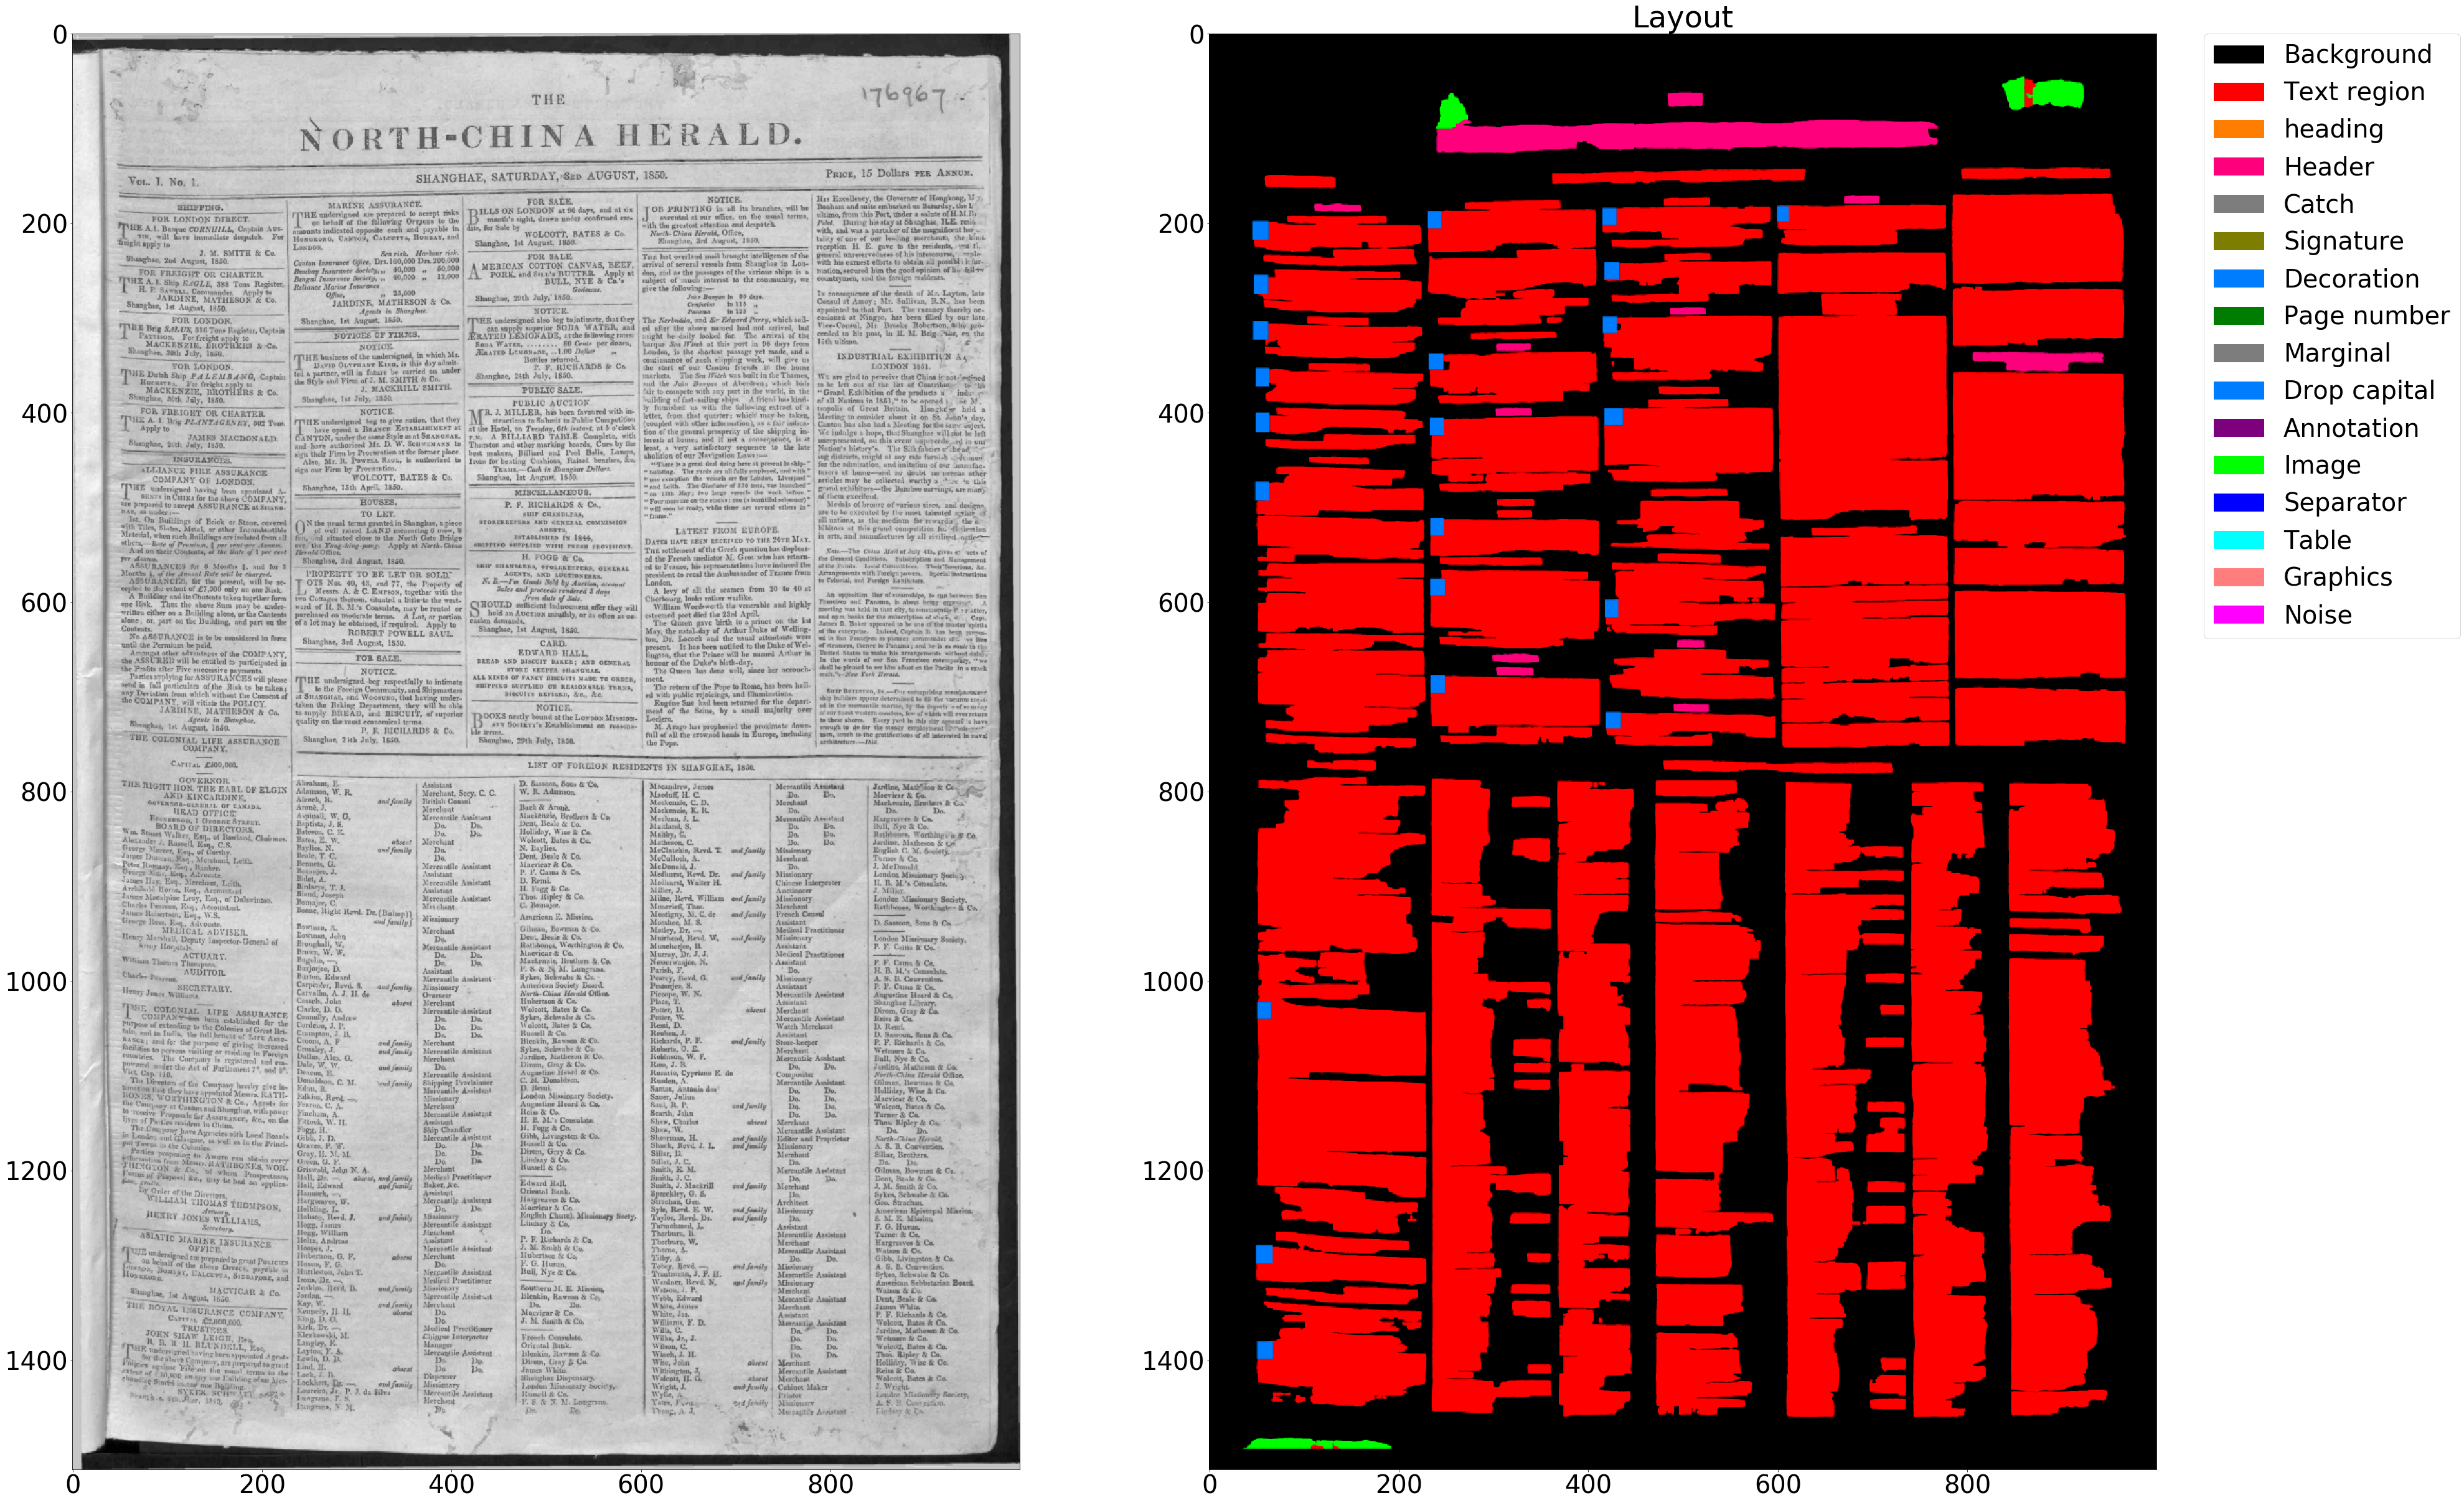

In [12]:
t0 = time.time()
run_every_thing (dir_of_xml_data, dir_of_image )
print('Elapsed time:' + str(time.time() - t0) )